In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import csv
from typing import Dict, List, Union
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from fastapi import FastAPI, Body
import seaborn as sb
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, roc_auc_score, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn import preprocessing
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

from sklearn import preprocessing


In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Base Class

In [ ]:
class DevicePricePredictor:
  def __init__(self, model_name:str):
    self.model_name = model_name
    self.features = []
    self.model = None

  def load_data(self, data_path: str) -> pd.DataFrame:
    """
      This function is used to load a csv data and gave an assumption that the last
      column is the labels column and change it's name to be taget
      Argumets:
        data_path(str):path to the dataset
      Returns:
        data(pd.DataFrame):loaded csv dataframe after changing the labels column name to target 
    """
    data = pd.read_csv(data_path)
    columns = list(data.columns)
    columns[-1] = 'target'
    data.columns = columns
    return data

  def perform_imputation(self,
                          data:Union[np.ndarray, pd.DataFrame]=None,
                          imputation_method:str='knn') -> pd.DataFrame:
    """
      This function is used to perform imputation on the passed dataset based on the imputation method decided
      Argumets:
        data(Union[np.ndarray, pd.DataFrame]):the dataset
        imputation_method(str):the imputation method that need to be applied
      Returns:
        data(pd.DataFrame):loaded csv dataframe after changing the labels column name to target 
    """
    if imputation_method =='mice':
      mice_imputer = IterativeImputer(random_state=100, max_iter=5)
      df_mice_imputed = mice_imputer.fit_transform(data)

      df_mice_imputed = pd.DataFrame(df_mice_imputed, columns=data.columns, index=data.index)
      data = df_mice_imputed

    elif imputation_method =='knn':
      imputer = KNNImputer(n_neighbors=5)
      filled_data = imputer.fit_transform(data)

      df_imputed = pd.DataFrame(filled_data, columns=data.columns, index=data.index)
      data = df_imputed

    return data

  def perform_eda(self,
                  data:Union[np.ndarray, pd.DataFrame]=None,
                  missing_values_per_feature_display:bool=False,
                  numerical_dist_display:bool=False,
                  explore_relash_display:bool=False,
                  corr_display:bool=True) -> None:
    """
      This function is used to perform EDA methods on the data
      Argumets:
        data(Union[np.ndarray, pd.DataFrame]):the dataset
        missing_values_per_feature_display(bool):boolean variable to decide whether to show missed values per features or not
        numerical_dist_display(bool):boolean variable to explore distribution of numerical features with histograms
        explore_relash_display(bool):boolean variable to explore relationships with scatter plots
        corr_display(bool):boolean variable to explore relationships between features using heatmap
      Returns:

    """

    if not isinstance(data, pd.DataFrame):
      data = pd.DataFrame(data)

    if missing_values_per_feature_display:
      # Create a bar chart to visualize missing values
      data.isnull().sum().plot(kind='bar')
      plt.title("Missing Values per Feature")
      plt.xlabel("Feature")
      plt.ylabel("Count of Missing Values")
      plt.show()

    if numerical_dist_display:
      # Explore distribution of numerical features with histograms
      for col in data.columns:
        if data[col].dtype != object:
          sb.histplot(data=data, x=col)
          plt.show()

    if explore_relash_display:
      # Explore relationships with scatter plots (consider using pairplots for many features)
      sb.scatterplot(x="battery_pe", y="price", data=data)
      plt.show()

    if corr_display:
      plt.figure(figsize=(20, 10))
      # plotting correlation heatmap
      dataplot = sb.heatmap(data.corr(), cmap="YlGnBu", annot=True)
      plt.show()



  def preprocess_data(self,
                      scaling_data:bool=False,
                      normalize:bool=False,
                      imputation:bool=False,
                      imputation_method:str='knn',
                      train:bool=True,
                      pca:bool=False,
                      data:Union[np.ndarray, pd.DataFrame]=None) -> Union[np.ndarray, pd.DataFrame]:
    """
      This function is used to perform preprocessing on the data
      Argumets:
        data(Union[np.ndarray, pd.DataFrame]):the dataset
        scaling_data(bool):boolean variable to decide whether to apply standardization or not
        normalize(bool):boolean variable to decide whether to apply normalization or not
        imputation(bool):boolean variable to decide whether to apply imputation or not
        pca(bool):boolean variable to decide whether to apply pca or not
        train(bool):boolean variable to decide whether the current data is training or not
        imputation_method(str):the imputation method name can be (knn, mice)
      Returns:
        data(Union[np.ndarray, pd.DataFrame])
    """

    if imputation:
      data = self.perform_imputation(data, imputation_method)

    if scaling_data:
      if train:
        self.scaler = preprocessing.StandardScaler().fit(data)
        data = self.scaler.transform(data)
      else:
        data = self.scaler.transform(data)

    if normalize:
      if train:
        self.scaler = preprocessing.Normalizer().fit(data)
        data = self.scaler.transform(data)
      else:
        data = self.scaler.transform(data)
    if pca:
      pca = PCA(n_components=0.95)  # Reduce to 95% variance
      data = pca.fit_transform(data)
    return data



  def train_model(self, X_train:np.ndarray, y_train:np.ndarray) -> None:
    """
      This function is used to create and fit the model chosen before
      Argumets:
        X_train(np.ndarray):the features
        y_train(np.ndarray):the labels
      Returns:
    """
    if self.model_name=='rf':
      self.model = RandomForestClassifier()
    elif self.model_name=='lr':
      self.model = LogisticRegression(random_state=42)
    elif self.model_name=='naive':
      self.model = GaussianNB()
    elif self.model_name=='svm':
      self.model = SVC(gamma='auto')
    elif self.model_name=='lir':
      self.model = LinearRegression()


    self.model.fit(X_train, y_train)

  def evaluate_model(self, X_test: np.ndarray[np.ndarray], y_test: np.ndarray) -> None:
      """
      This function is used to evaluated the fitted model
      Argumets:
        X_test(np.ndarray):the features
        y_test(np.ndarray):the labels
      Returns:
      """
      # Predict on test data
      y_pred = self.model.predict(X_test)

      # Calculate metrics (assuming target variable is discretized into price categories)
      print("Classification Report:")
      print(classification_report(y_test, y_pred))

      # Confusion Matrix (assuming target variable is discretized into price categories)
      cm = confusion_matrix(y_test, y_pred)
      print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
      print("Recall:", recall_score(y_test, y_pred, average='weighted'))
      print("Precision:", precision_score(y_test, y_pred, average='weighted'))
      print("Accuracy:", accuracy_score(y_test, y_pred))
      print('------------------------------------------')

      self.plot_confusion_matrix(cm)


  def predict_price(self, X_test:np.ndarray[np.ndarray]=None) -> np.ndarray:
    """
    This function is used to predict using the fitted model
    Argumets:
      X_test(np.ndarray):the features
      y_test(np.ndarray):the labels
    Returns:
      y_pred(np.ndarray):models predictions
    """
    if len(X_test.shape)==1:
      X_test = X_test.reshape(1, -1)
    y_pred = self.model.predict(X_test)
    return y_pred

  def plot_confusion_matrix(self, cm: np.ndarray) -> None:
    """
    This function is used to plot the confusion matrix 
    Argumets:
      cm(np.ndarray):confusion matrix values
    Returns:
    """

    # Normalize confusion matrix (optional)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a new figure for the plot
    plt.figure(figsize=(8, 6))

    # Create heatmap with annotations
    sb.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted Price')
    plt.ylabel('True Price')
    plt.title('Confusion Matrix')
    plt.show()

  def set_model_name(self, model_name:str='rf'):
    """
    This function is cahnge the models name basically
    Argumets:
      model_name(str):new name for the model
    Returns:
    """
    self.model_name = model_name


## EDA and Identifying Parameters

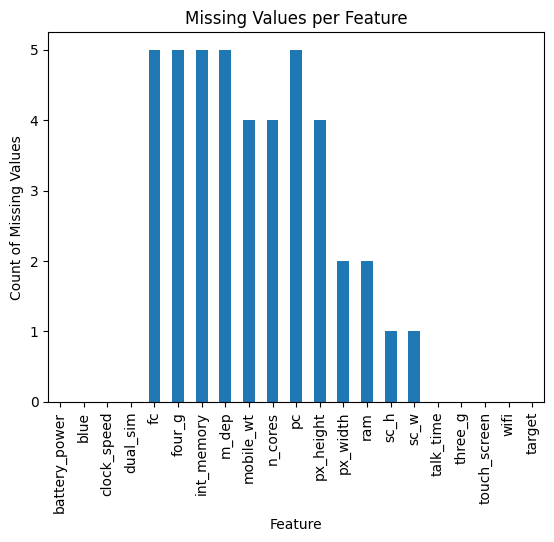

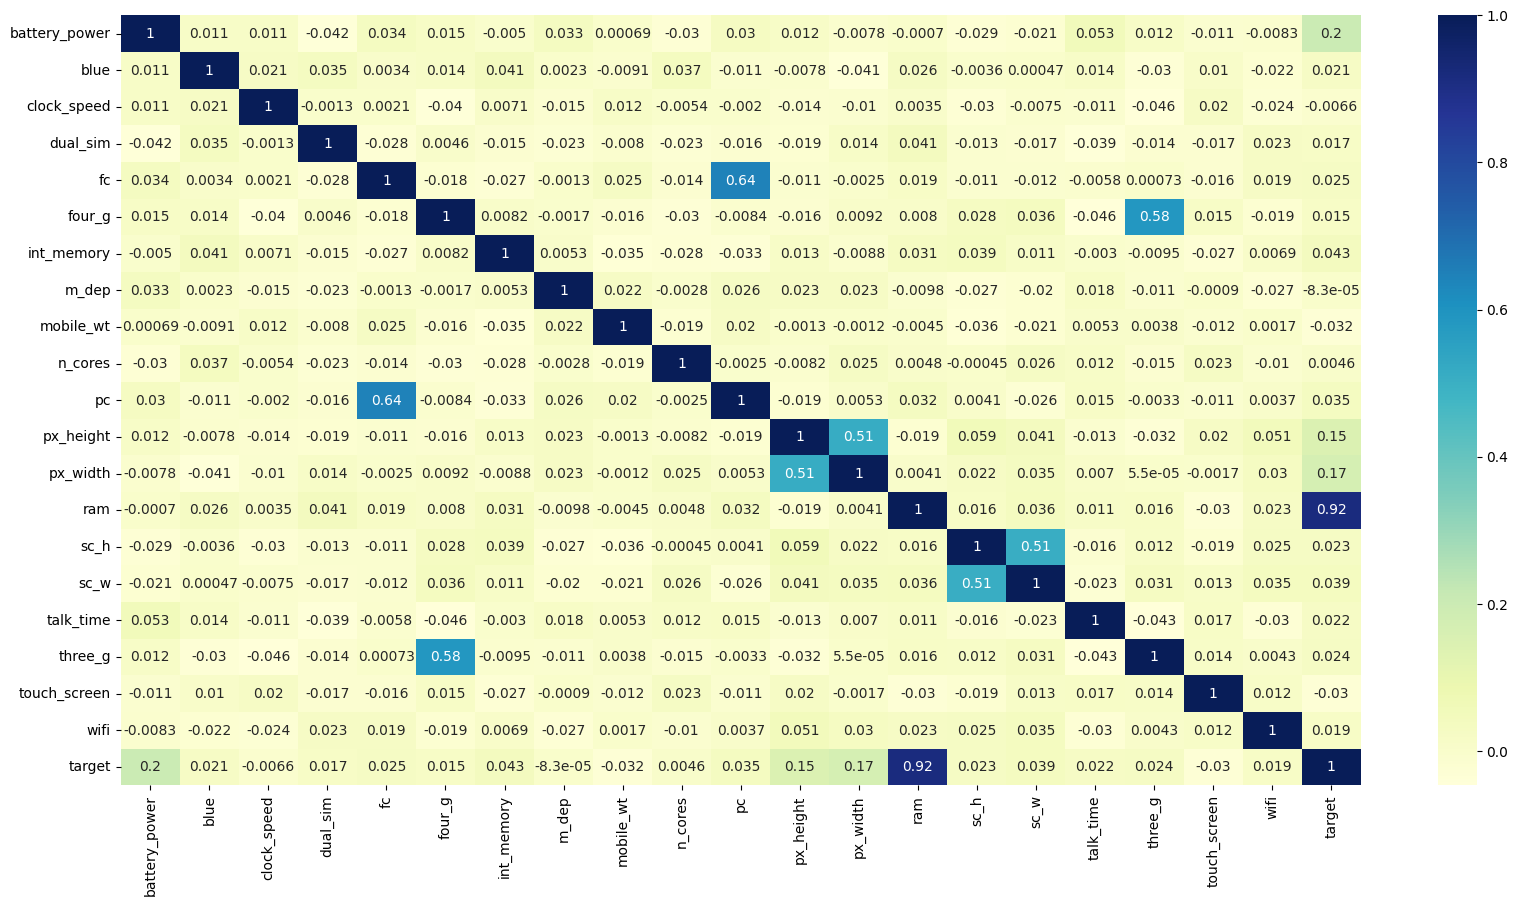

In [ ]:
data_path = '/content/drive/MyDrive/Device Project/train - train.csv'
model_name = 'naive'
imputation_method = 'knn'
scaling_data=False
normalize=False
imputation=True
train=True
pca=False
imputation = True
missing_values_per_feature_display=True
numerical_dist_display=False
explore_relash_display=False
corr_display=True

device_model = DevicePricePredictor(model_name)
data = device_model.load_data(data_path)
device_model.perform_eda(data=data,
                         missing_values_per_feature_display=missing_values_per_feature_display)

## Check for linearity of the dataset

In [ ]:
model_name = 'lir'
scaling_data=True
normalize=False

device_model.set_model_name(model_name)
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, imputation_method=imputation_method, imputation=imputation)
X_train = X_train.values
device_model.train_model(X_train, y_train)


In [ ]:
X_test = device_model.preprocess_data(data=X_test, imputation_method=imputation_method, imputation=imputation)
X_test = X_test.values
y_pred = device_model.predict_price(X_test)

slope, intercept, r_value, p_value, std_err = linregress(y_test, y_pred)

# Interpretation
print("R-squared:", r_value**2)  # Square r_value to get R-squared
print("p-value:", p_value)

R-squared: 0.9189096002778773
p-value: 8.031288396531198e-274


Beacause of the high value of the R-Squared I can say the data is linear and all the linear functions can be applied to it

Before applying any preprocessing methods on the data I will apply the baseline model which is going to be Naive bayse, but since I have NaN values in the data based on the above plot I only need to perform imputation; I have decided to use either KNN or MICE as an imputation method

## Baseline Model (Naive-bayse)

In [ ]:
model_name = 'naive'
scaling_data=True
normalize=False
device_model.set_model_name(model_name)

y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, imputation_method=imputation_method, imputation=imputation)
X_train = X_train.values
device_model.train_model(X_train, y_train)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       125
           1       0.71      0.68      0.70       125
           2       0.68      0.70      0.69       125
           3       0.89      0.92      0.91       125

    accuracy                           0.80       500
   macro avg       0.80      0.80      0.80       500
weighted avg       0.80      0.80      0.80       500

F1 Score: 0.8038765310018319
Recall: 0.804
Precision: 0.8042769722335106
Accuracy: 0.804
------------------------------------------


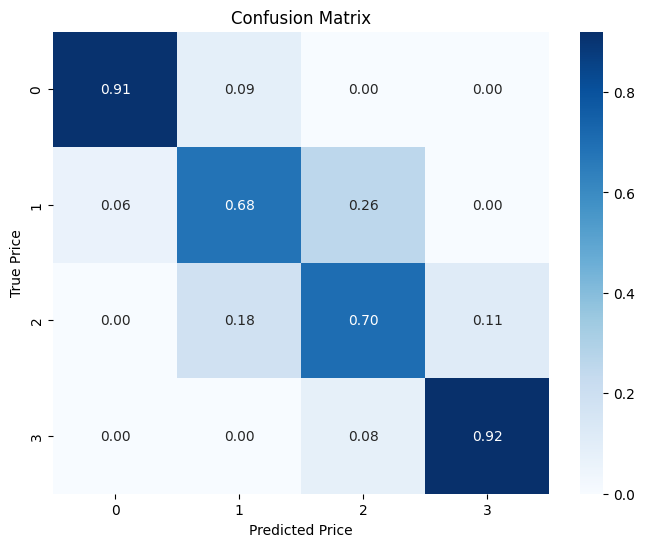

In [ ]:
X_test = device_model.preprocess_data(data=X_test, imputation_method=imputation_method, imputation=imputation)
X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

## Logistic Regression Model

Since I want to apply a new approach and a new model which I want it to be better than the previous one.
So, I am going to apply the suggested preprocessing method.
Firstly I will apply Standardization

### Applying Standardization

In [ ]:
model_name = 'lr'
scaling_data=True
normalize=False
device_model.set_model_name(model_name)
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, scaling_data=scaling_data, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       125
           1       0.94      0.95      0.95       125
           2       0.94      0.94      0.94       125
           3       0.95      0.98      0.97       125

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500

F1 Score: 0.9580199751411885
Recall: 0.958
Precision: 0.9583041852060812
Accuracy: 0.958
------------------------------------------


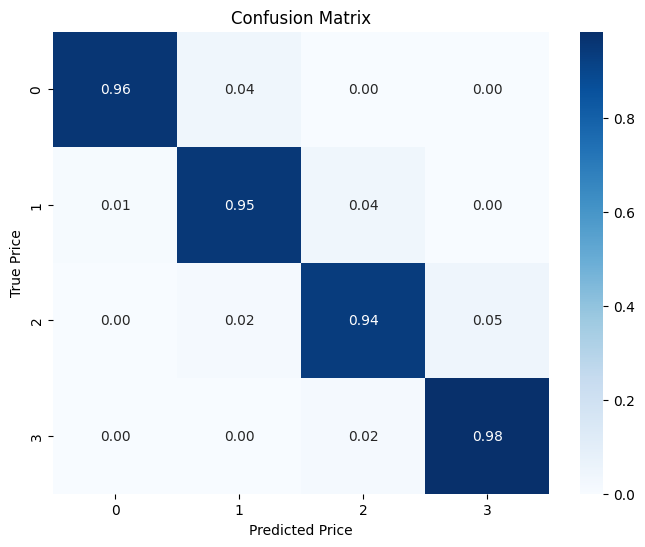

In [ ]:
train=False
X_test = device_model.preprocess_data(data=X_test, imputation_method=imputation_method, imputation=imputation, scaling_data=scaling_data, train=train)
if not isinstance(X_train, np.ndarray):
  X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

### Normalization

In [ ]:
normalize=True
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, normalize=normalize, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76       125
           1       0.45      0.41      0.43       125
           2       0.44      0.31      0.37       125
           3       0.56      0.75      0.64       125

    accuracy                           0.56       500
   macro avg       0.55      0.56      0.55       500
weighted avg       0.55      0.56      0.55       500

F1 Score: 0.5488494911894697
Recall: 0.562
Precision: 0.5490569737280264
Accuracy: 0.562
------------------------------------------


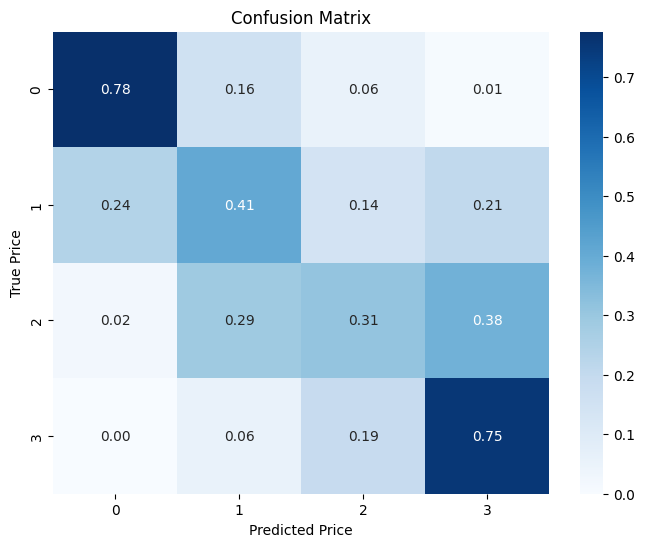

In [ ]:
train=False
X_test = device_model.preprocess_data(data=X_test, normalize=normalize, imputation_method=imputation_method, imputation=imputation, train=train)
if not isinstance(X_train, np.ndarray):
  X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

### PCA

In [ ]:
pca=True
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, pca=pca, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.29      0.30      0.30       125
           2       0.22      0.18      0.20       125
           3       0.00      0.00      0.00       125

    accuracy                           0.12       500
   macro avg       0.13      0.12      0.12       500
weighted avg       0.13      0.12      0.12       500

F1 Score: 0.12361694677871148
Recall: 0.12
Precision: 0.12863247863247865
Accuracy: 0.12
------------------------------------------


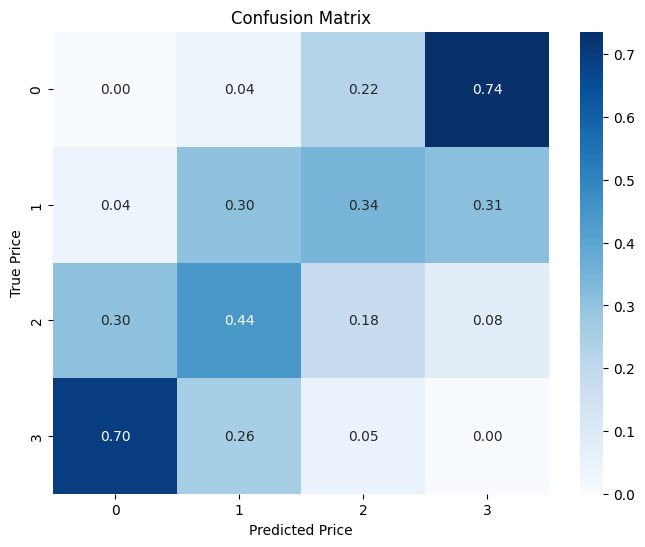

In [ ]:
train=False
X_test = device_model.preprocess_data(data=X_test, pca=pca, imputation_method=imputation_method, imputation=imputation, train=train)
if not isinstance(X_train, np.ndarray):
  X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

### No preprocessing

In [ ]:
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       125
           1       0.52      0.53      0.52       125
           2       0.41      0.42      0.42       125
           3       0.68      0.70      0.69       125

    accuracy                           0.61       500
   macro avg       0.62      0.61      0.61       500
weighted avg       0.62      0.61      0.61       500

F1 Score: 0.6143180012843957
Recall: 0.612
Precision: 0.6173415894669516
Accuracy: 0.612
------------------------------------------


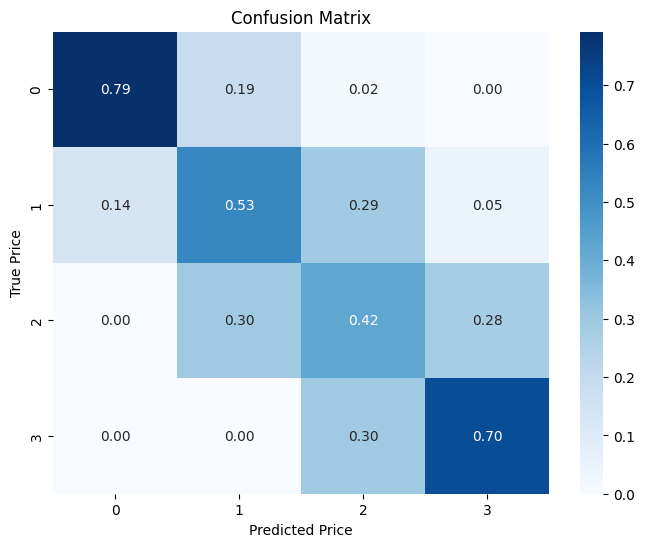

In [ ]:
X_test = device_model.preprocess_data(data=X_test, imputation_method=imputation_method, imputation=imputation)
X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

## Random Forest Model

Since I want to apply a new approach and a new model which I want it to be better than the previous one.
So, I am going to apply the suggested preprocessing method.
Firstly I will apply Standardization

### Applying Standardization

In [ ]:
model_name = 'rf'
scaling_data=True
normalize=False
device_model.set_model_name(model_name)
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, scaling_data=scaling_data, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       125
           1       0.81      0.82      0.81       125
           2       0.79      0.75      0.77       125
           3       0.90      0.94      0.92       125

    accuracy                           0.87       500
   macro avg       0.86      0.87      0.87       500
weighted avg       0.86      0.87      0.87       500

F1 Score: 0.8652347751088607
Recall: 0.866
Precision: 0.8649701385109572
Accuracy: 0.866
------------------------------------------


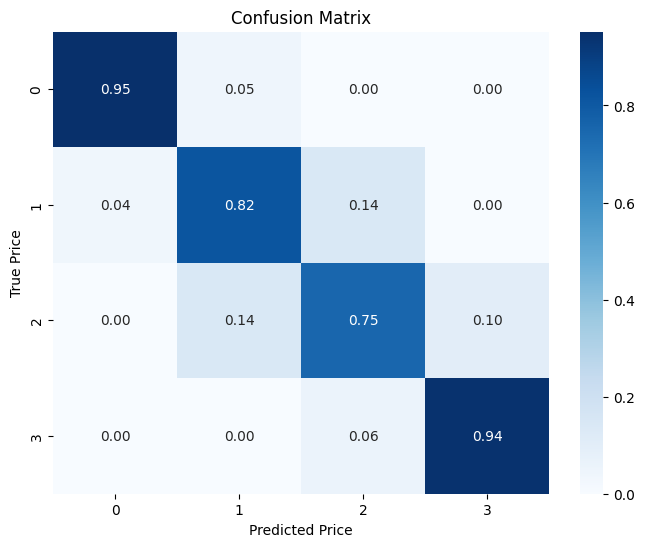

In [ ]:
train=False
X_test = device_model.preprocess_data(data=X_test, imputation_method=imputation_method, imputation=imputation, scaling_data=scaling_data, train=train)
if not isinstance(X_train, np.ndarray):
  X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

### Normalization

In [ ]:
normalize=True
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, normalize=normalize, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       125
           1       0.91      0.93      0.92       125
           2       0.91      0.92      0.92       125
           3       0.94      0.95      0.94       125

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500

F1 Score: 0.9341978866681198
Recall: 0.934
Precision: 0.9347873910062713
Accuracy: 0.934
------------------------------------------


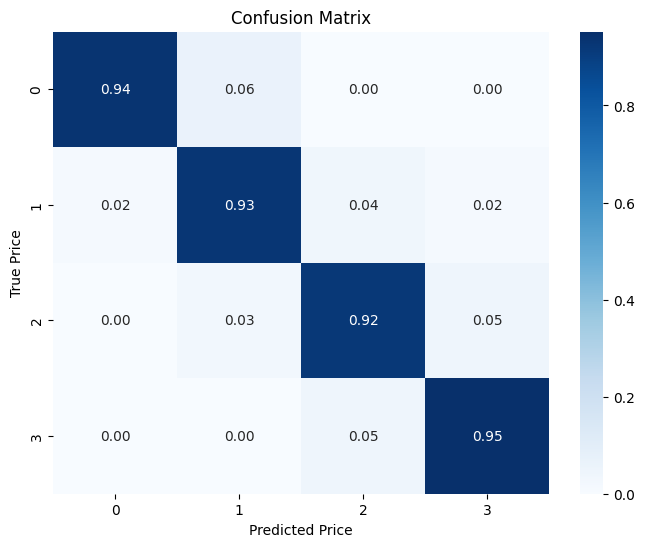

In [ ]:
train=False
X_test = device_model.preprocess_data(data=X_test, normalize=normalize, imputation_method=imputation_method, imputation=imputation, train=train)
if not isinstance(X_train, np.ndarray):
  X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

### PCA

In [ ]:
pca=True
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, pca=pca, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       125
           1       0.29      0.28      0.28       125
           2       0.19      0.18      0.19       125
           3       0.00      0.00      0.00       125

    accuracy                           0.12       500
   macro avg       0.12      0.12      0.12       500
weighted avg       0.12      0.12      0.12       500

F1 Score: 0.11778897793935389
Recall: 0.116
Precision: 0.11963797814207651
Accuracy: 0.116
------------------------------------------


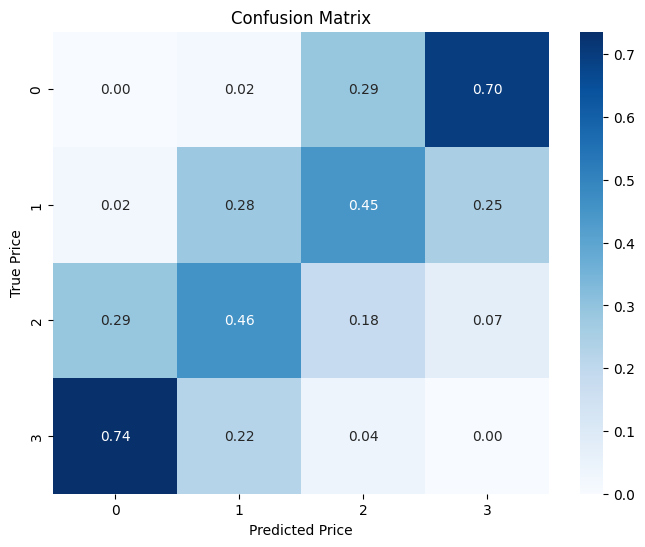

In [ ]:
train=False
X_test = device_model.preprocess_data(data=X_test, pca=pca, imputation_method=imputation_method, imputation=imputation, train=train)
if not isinstance(X_train, np.ndarray):
  X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data

### No preprocessing

In [ ]:
y_train = data['target'].values
X_train = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

X_train = device_model.preprocess_data(data=X_train, imputation_method=imputation_method, imputation=imputation)
if not isinstance(X_train, np.ndarray):
  X_train = X_train.values
device_model.train_model(X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       125
           1       0.84      0.86      0.85       125
           2       0.82      0.77      0.79       125
           3       0.89      0.94      0.92       125

    accuracy                           0.88       500
   macro avg       0.88      0.88      0.88       500
weighted avg       0.88      0.88      0.88       500

F1 Score: 0.8811845345970882
Recall: 0.882
Precision: 0.8811784587438639
Accuracy: 0.882
------------------------------------------


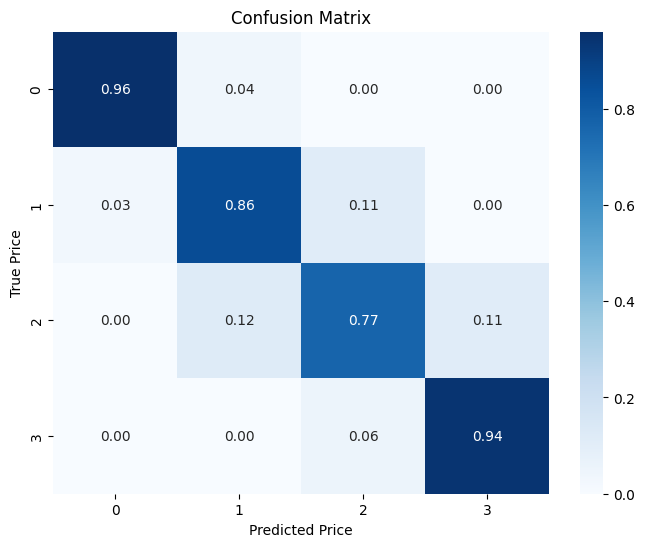

In [ ]:
X_test = device_model.preprocess_data(data=X_test, imputation_method=imputation_method, imputation=imputation)
X_test = X_test.values
device_model.evaluate_model(X_test, y_test)
# test_data